In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 252, 64)        │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 126, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,177 (180.38 KB)

 Trainable params: 46,177 (180.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5216 - loss: 0.6892 - val_accuracy: 0.5168 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 2/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.5470 - loss: 0.6831 - val_accuracy: 0.4947 - val_loss: 0.6926 - learning_rate: 0.0010
Epoch 3/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5216 - loss: 0.6936 - val_accuracy: 0.5517 - val_loss: 0.6711 - learning_rate: 0.0010
Epoch 4/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5484 - loss: 0.6722 - val_accuracy: 0.5464 - val_loss: 0.6757 - learning_rate: 0.0010
Epoch 5/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.5612 - loss: 0.6699 - val_accuracy: 0.5527 - val_loss: 0.6654 - learning_rate: 0.0010
Epoch 6/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5506 - loss: 0.6722 - val_accuracy: 0.5481 - val_loss: 0.6682 - learning_rate: 0.0010
Epoch 7/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5656 - loss:

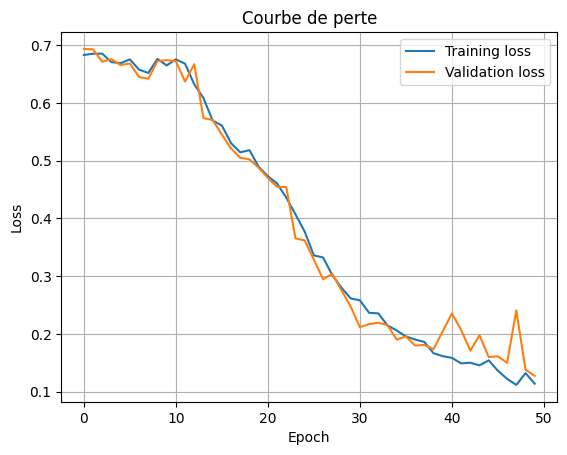

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

# === PARAMÈTRES ===
base_path = '/content/drive/MyDrive/Classification_data'
window_size = 256
step_size = 128
max_len = window_size  # Longueur des séquences d'entrée

# === FONCTIONS ===

def normalize_signal(signal):
    """Normalisation Z-score."""
    return (signal - np.mean(signal)) / np.std(signal)

def load_data_by_group(data_dir, group_name, label):
    X, y = [], []
    files = sorted([f for f in os.listdir(data_dir) if group_name in f and f.endswith('.csv')])
    for fname in files:
        df = pd.read_csv(os.path.join(data_dir, fname))
        if 'left_signal' not in df.columns or 'right_signal' not in df.columns:
            continue
        left = normalize_signal(df['left_signal'].values)
        right = normalize_signal(df['right_signal'].values)
        combined = np.stack([left, right], axis=1)

        for i in range(0, len(combined) - window_size, step_size):
            window = combined[i:i + window_size]
            X.append(window)
            y.append(label)
    return np.array(X), np.array(y)

# === CHARGEMENT DES DONNÉES ===
X_control, y_control = load_data_by_group(base_path, 'control', 0)
X_hunt, y_hunt = load_data_by_group(base_path, 'hunt', 1)

X = np.concatenate([X_control, X_hunt], axis=0)
y = np.concatenate([y_control, y_hunt], axis=0)

X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === MODÈLE CNN + LSTM ===

def build_cnn_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn_lstm_model((max_len, 2))
model.summary()

# === CALLBACK ===
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# === ENTRAÎNEMENT ===
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[lr_scheduler],
    verbose=1
)

# === ÉVALUATION ===
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.2f}")

# === COURBE DE PERTE ===
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de perte")
plt.legend()
plt.grid(True)
plt.show()


144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9684 - loss: 0.1148
Test Accuracy: 0.97


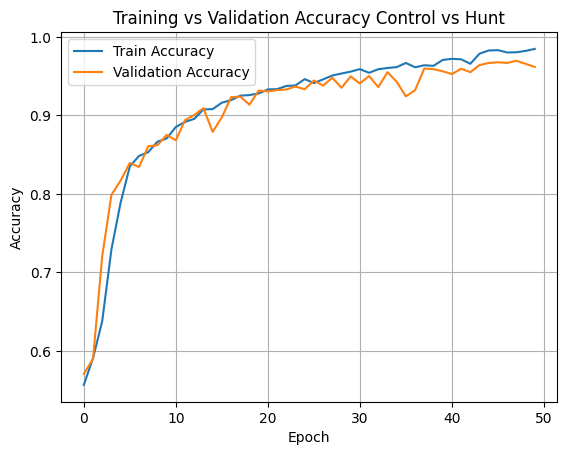

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy Control vs Hunt")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score

#Prédictions sur l'ensemble de test,
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

#Affichage des métriques,
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1-score: {f1:.2f}")

#Rapport détaillé,
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Control", "HUNT"]))

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test Accuracy: 0.96
Test Recall: 0.95
Test F1-score: 0.96

Classification Report:
              precision    recall  f1-score   support

     Control       0.96      0.96      0.96      2585
        HUNT       0.96      0.95      0.96      2524

    accuracy                           0.96      5109
   macro avg       0.96      0.96      0.96      5109
weighted avg       0.96      0.96      0.96      5109



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 252, 64)        │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 126, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 126, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,177 (180.38 KB)

 Trainable params: 46,177 (180.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5574 - loss: 0.6867 - val_accuracy: 0.5709 - val_loss: 0.6781 - learning_rate: 0.0010
Epoch 2/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5901 - loss: 0.6713 - val_accuracy: 0.5900 - val_loss: 0.6738 - learning_rate: 0.0010
Epoch 3/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.6181 - loss: 0.6555 - val_accuracy: 0.7208 - val_loss: 0.5852 - learning_rate: 0.0010
Epoch 4/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.6962 - loss: 0.5963 - val_accuracy: 0.7988 - val_loss: 0.4416 - learning_rate: 0.0010
Epoch 5/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7835 - loss: 0.4691 - val_accuracy: 0.8171 - val_loss: 0.3944 - learning_rate: 0.0010
Epoch 6/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8298 - loss: 0.3797 - val_accuracy: 0.8394 - val_loss: 0.3576 - learning_rate: 0.0010
Epoch 7/50
459/459 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.8474 - lo

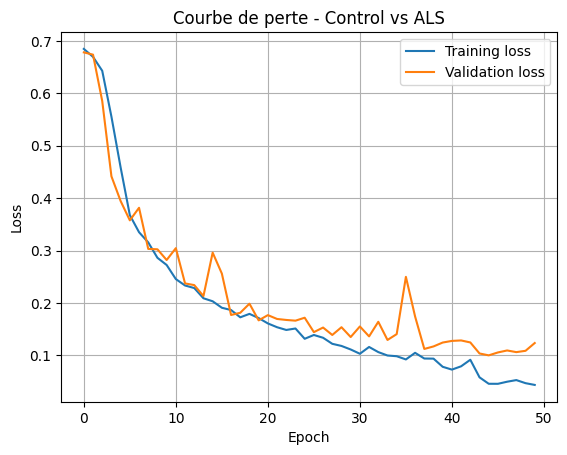

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt

# === PARAMÈTRES ===
base_path = '/content/drive/MyDrive/Classification_data'
window_size = 256
step_size = 128
max_len = window_size

# === FONCTIONS ===

def normalize_signal(signal):
    return (signal - np.mean(signal)) / np.std(signal)

def load_data_by_group(data_dir, group_name, label):
    X, y = [], []
    files = sorted([f for f in os.listdir(data_dir) if group_name in f and f.endswith('.csv')])
    for fname in files:
        df = pd.read_csv(os.path.join(data_dir, fname))
        if 'left_signal' not in df.columns or 'right_signal' not in df.columns:
            continue
        left = normalize_signal(df['left_signal'].values)
        right = normalize_signal(df['right_signal'].values)
        combined = np.stack([left, right], axis=1)

        for i in range(0, len(combined) - window_size, step_size):
            window = combined[i:i + window_size]
            X.append(window)
            y.append(label)
    return np.array(X), np.array(y)

# === CHARGEMENT DES DONNÉES ===
X_control, y_control = load_data_by_group(base_path, 'control', 0)
X_als, y_als = load_data_by_group(base_path, 'als', 1)

X = np.concatenate([X_control, X_als], axis=0)
y = np.concatenate([y_control, y_als], axis=0)

X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === MODÈLE CNN + LSTM ===

def build_cnn_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn_lstm_model((max_len, 2))
model.summary()

# === CALLBACK ===
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# === ENTRAÎNEMENT ===
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[lr_scheduler],
    verbose=1
)

# === ÉVALUATION ===
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy (Control vs ALS): {test_acc:.2f}")

# === COURBE DE PERTE ===
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Courbe de perte - Control vs ALS")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Prédictions sur l'ensemble de test,
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

#Affichage des métriques,
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Test Recall: {recall:.2f}")
print(f"Test F1-score: {f1:.2f}")

#Rapport détaillé,
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Control", "ALS"]))

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test Accuracy: 0.97
Test Recall: 0.95
Test F1-score: 0.96

Classification Report:
              precision    recall  f1-score   support

     Control       0.96      0.98      0.97      2512
         ALS       0.97      0.95      0.96      2073

    accuracy                           0.97      4585
   macro avg       0.97      0.96      0.97      4585
weighted avg       0.97      0.97      0.97      4585

